In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
from tqdm import tqdm_notebook
import time
import matplotlib.pyplot as plt
from PIL import Image
import random
random.seed(42)
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorlayer as tl
sess = tf.InteractiveSession()

In [3]:
img_list = !ls data/train/
for i in range(len(img_list)):
    img_list[i] = 'data/train/' + img_list[i]

In [4]:
class data_aug():
    def __init__(self, sess, img_list, crops_per_img=10, 
                 save_dir='aug_data/', crop_size=(128, 128, 3), 
                 aug_types=['flip_left_right', 'rotate', 'zoom']):
        self.session = sess
        self.img_list = img_list
        self.crops_per_img = crops_per_img
        self.aug_types = aug_types
        self.crop_list = []
        self.save_dir = save_dir
        self.crop_size = (128, 128, 3)
        self.cnt = 0
        
    def open_file_crop(self):
        sta = self.cnt
        for idx, img in enumerate(self.img_list[sta:]):
            st = time.time()
            aug_imgs = self._apply_aug(img)
            self._save_imgs(aug_imgs, idx)
            self.cnt = idx
            ed = time.time()
            print('crop {0}/{1}\t{2}'.format(idx, len(self.img_list[sta:]), ed - st))
    
    def _apply_aug(self, img):
        img = np.array(Image.open(img))
        
        return_list = []
        img_f = tl.prepro.flip_axis(img, axis=1)
        img_z = tl.prepro.zoom(img, is_random=True)
        img_r = tl.prepro.rotation(img, is_random=True)
        
        for i in range(self.crops_per_img):
            return_list.append(tl.prepro.crop(img, self.crop_size[0], self.crop_size[1]))
            return_list.append(tl.prepro.crop(img_f, self.crop_size[0], self.crop_size[1]))
            return_list.append(tl.prepro.crop(img_z, self.crop_size[0], self.crop_size[1]))
            return_list.append(tl.prepro.crop(img_r, self.crop_size[0], self.crop_size[1]))
        return return_list
        
    def _save_imgs(self, img_list, idx):
        for i in range(len(img_list)):
            tl.vis.save_image(img_list[i], os.path.join(self.save_dir, '{0}_aug_{1}.png'.format(idx, i)))

In [5]:
da = data_aug(sess, img_list)

In [6]:
print('')
#da.open_file_crop()

In [7]:
da.crop_list = !ls aug_data/
temp_list = []
for i in range(len(da.crop_list)):
    temp_list.append('aug_data/' + da.crop_list[i])
da.crop_list = temp_list

In [8]:
import random
random.shuffle(da.crop_list)

In [9]:
len(da.crop_list)

41920

In [10]:
def show_crops(crop_list, idx):
    idx = int(idx / 10) * 10
    s_idx = idx - 10
    crop_list = crop_list[s_idx:idx]
    for i in range(1, 11):
        plt.subplot(2,5,i)
        plt.imshow(np.array(Image.open(crop_list[i - 1])))
        plt.axis('off')
    plt.show()

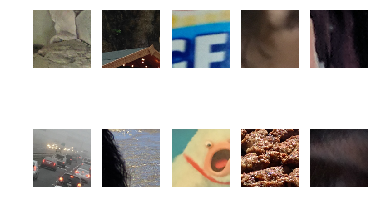

In [11]:
show_crops(da.crop_list, 452)

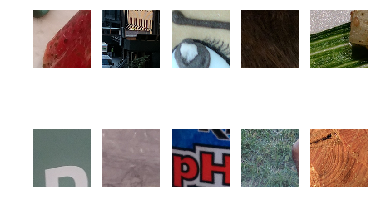

In [12]:
show_crops(da.crop_list, 8732)

In [13]:
import pandas as pd

In [14]:
df = pd.DataFrame()
df['path'] = np.array(da.crop_list[:int(len(da.crop_list)*0.8)]).astype(np.object)
df.to_hdf('data/CLIC_train.h5', 'path')

In [15]:
df = pd.DataFrame()
df['path'] = np.array(da.crop_list[int(len(da.crop_list)*0.8):]).astype(np.object)
df.to_hdf('data/CLIC_test.h5', 'path')

In [4]:
??tf.image.ssim_multiscale()

Signature: tf.image.ssim_multiscale(img1, img2, max_val, power_factors=(0.0448, 0.2856, 0.3001, 0.2363, 0.1333))
Source:   
@tf_export('image.ssim_multiscale')
def ssim_multiscale(img1, img2, max_val, power_factors=_MSSSIM_WEIGHTS):
  """Computes the MS-SSIM between img1 and img2.

  This function assumes that `img1` and `img2` are image batches, i.e. the last
  three dimensions are [height, width, channels].

  Note: The true SSIM is only defined on grayscale.  This function does not
  perform any colorspace transform.  (If input is already YUV, then it will
  compute YUV SSIM average.)

  Original paper: Wang, Zhou, Eero P. Simoncelli, and Alan C. Bovik. "Multiscale
  structural similarity for image quality assessment." Signals, Systems and
  Computers, 2004.

  Arguments:
    img1: First image batch.
    img2: Second image batch. Must have the same rank as img1.
    max_val: The dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed value